In [2]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
import re           
from bs4 import BeautifulSoup 
import tensorflow as tf
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [3]:
# Çalışmada kullanacağım veri setini yükledim.
from datasets import load_dataset

dataset = load_dataset("amazon_reviews_multi", "all_languages")

Found cached dataset amazon_reviews_multi (C:/Users/KARACIK/.cache/huggingface/datasets/amazon_reviews_multi/all_languages/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# Veri setini tanımaya çalıştım.
dataset

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 1200000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 30000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 30000
    })
})

In [5]:
# Train bölümündeki verileri pandas DataFrame'e dönüştürdüm.
train_data = pd.DataFrame(dataset['train'])

# Validation bölümündeki verileri pandas DataFrame'e dönüştürdüm.
validation_data = pd.DataFrame(dataset['validation'])

# Test bölümündeki verileri pandas DataFrame'e dönüştürdüm.
test_data = pd.DataFrame(dataset['test'])

In [6]:
# Sonraki aşamalarda yapacağım işlemleri tüm veri üzerinde yapmak ve veriyi bölme işlemini istediğim gibi yapmak için tüm verileri birleştirdim.
data = pd.concat([train_data , validation_data , test_data ])

In [7]:
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,de_0203609,product_de_0865382,reviewer_de_0267719,1,Armband ist leider nach 1 Jahr kaputt gegangen,Leider nach 1 Jahr kaputt,de,sports
1,de_0559494,product_de_0678997,reviewer_de_0783625,1,In der Lieferung war nur Ein Akku!,EINS statt ZWEI Akkus!!!,de,home_improvement
2,de_0238777,product_de_0372235,reviewer_de_0911426,1,"Ein Stern, weil gar keine geht nicht. Es handelt sich um gebraucht Waren, die Stein haben so ein Belag drauf, wo man sich dabei denken kann, dass jemand schon die benutzt und nicht Mal richtig gew...",Achtung Abzocke,de,drugstore
3,de_0477884,product_de_0719501,reviewer_de_0836478,1,"Dachte, das wären einfach etwas festere Binden, vielleicht größere Always. Aber die Verpackung ist derartig riesig - wie als hätte man einen riesigen Karton Windeln gekauft... nicht das, was ich w...",Zu viel des Guten,de,drugstore
4,de_0270868,product_de_0022613,reviewer_de_0736276,1,Meine Kinder haben kaum damit gespielt und nach 6 Monaten riss es an der Naht obwohl ich sehr leichte Kinder habe.,Qualität sehr schlecht,de,toy


In [8]:
data_en = data[data["language"] == "en"]

In [9]:
data_en.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
200000,en_0964290,product_en_0740675,reviewer_en_0342986,1,"Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing t...",I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review ...,en,furniture
200001,en_0690095,product_en_0440378,reviewer_en_0133349,1,the cabinet dot were all detached from backing... got me,Not use able,en,home_improvement
200002,en_0311558,product_en_0399702,reviewer_en_0152034,1,I received my first order of this product and it was broke so I ordered it again. The second one was broke in more places than the first. I can't blame the shipping process as it's shrink wrapped ...,The product is junk.,en,home
200003,en_0044972,product_en_0444063,reviewer_en_0656967,1,"This product is a piece of shit. Do not buy. Doesn't work, and then I try to call for customer support, it won't take my number. Fucking rip off!",Fucking waste of money,en,wireless
200004,en_0784379,product_en_0139353,reviewer_en_0757638,1,went through 3 in one day doesn't fit correct and couldn't get bubbles out (better without),bubble,en,pc


In [10]:
data_en.shape

(210000, 8)

In [11]:
#data_en = data_en[:100]

In [12]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [13]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #kısa kelimeleri kaldırma
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_review_body = []
for t in data_en['review_body']:
    cleaned_review_body.append(text_cleaner(t))

In [14]:
data_en["review_title"][:10]

200000    I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review ...
200001                                                                                                       Not use able
200002                                                                                               The product is junk.
200003                                                                                             Fucking waste of money
200004                                                                                                             bubble
200005                                                                  Poor quality. The material was fuzzy from day one
200006                                                                                                    Not reliable ☹️
200007                                                                                                     Waste of money
200008                  

In [15]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_review_title = []
for t in data_en['review_title']:
    cleaned_review_title.append(summary_cleaner(t))

data_en['cleaned_review_body']=cleaned_review_body
data_en['cleaned_review_title']=cleaned_review_title
data_en['cleaned_review_title'].replace('', np.nan, inplace=True)
data_en.dropna(axis=0,inplace=True)

In [16]:
data_en['cleaned_review_title'] = data_en['cleaned_review_title'].apply(lambda x : '_START_ '+ x + ' _END_')


In [17]:
data_en["cleaned_review_body"][0:5]

200000    arrived broken manufacturer defect two legs base completely formed way insert casters unpackaged entire chair hardware noticing spend twice amount time boxing whole useless thing send back star re...
200001                                                                                                                                                                           cabinet dot detached backing got
200002                                                                                received first order product broke ordered second one broke places first cannot blame shipping process shrink wrapped boxed
200003                                                                                                                              product piece shit buy work try call customer support take number fucking rip
200004                                                                                                                                                          

In [18]:
data_en["cleaned_review_title"][0:5]

200000    _START_ will spend twice the amount of time boxing up the whole useless thing and send it back with star review  _END_
200001                                                                                               _START_ not use able  _END_
200002                                                                                        _START_ the product is junk  _END_
200003                                                                                     _START_ fucking waste of money  _END_
200004                                                                                                     _START_ bubble  _END_
Name: cleaned_review_title, dtype: object

In [19]:
data_en.columns

Index(['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body',
       'review_title', 'language', 'product_category', 'cleaned_review_body',
       'cleaned_review_title'],
      dtype='object')

In [20]:
data_en = data_en.drop(['review_id', 'product_id', 'reviewer_id', 'stars', 'language', 'product_category'] , axis= 1 )

In [21]:
data_en.head()

,review_body,review_title,cleaned_review_body,cleaned_review_title
200000,"Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing t...",I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review ...,arrived broken manufacturer defect two legs base completely formed way insert casters unpackaged entire chair hardware noticing spend twice amount time boxing whole useless thing send back star re...,_START_ will spend twice the amount of time boxing up the whole useless thing and send it back with star review _END_
200001,the cabinet dot were all detached from backing... got me,Not use able,cabinet dot detached backing got,_START_ not use able _END_
200002,I received my first order of this product and it was broke so I ordered it again. The second one was broke in more places than the first. I can't blame the shipping process as it's shrink wrapped ...,The product is junk.,received first order product broke ordered second one broke places first cannot blame shipping process shrink wrapped boxed,_START_ the product is junk _END_
200003,"This product is a piece of shit. Do not buy. Doesn't work, and then I try to call for customer support, it won't take my number. Fucking rip off!",Fucking waste of money,product piece shit buy work try call customer support take number fucking rip,_START_ fucking waste of money _END_
200004,went through 3 in one day doesn't fit correct and couldn't get bubbles out (better without),bubble,went one day fit correct could get bubbles,_START_ bubble _END_


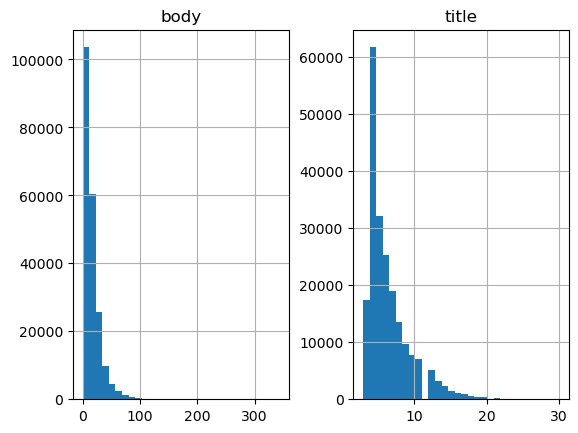

In [22]:
review_body_word_count = []
review_title_word_count = []

# populate the lists with sentence lengths
for i in data_en['cleaned_review_body']:
      review_body_word_count.append(len(i.split()))

for i in data_en['cleaned_review_title']:
      review_title_word_count.append(len(i.split()))

length_df = pd.DataFrame({'body':review_body_word_count, 'title':review_title_word_count})
length_df.hist(bins = 30)
plt.show()

In [23]:
max_len_body = 200
max_len_title = 25
latent_dim = 128


In [24]:
x_train, x_val, y_train, y_val = train_test_split(data_en['cleaned_review_body'], data_en['cleaned_review_title'], test_size=0.2, random_state=42, shuffle=True)


In [25]:
x_train.shape

(167535,)

In [26]:
x_val.shape

(41884,)

In [27]:
y_train.shape

(167535,)

In [28]:
y_val.shape

(41884,)

In [29]:
type(data_en)

pandas.core.frame.DataFrame

In [30]:
# Review Body için Tokenizer ve dönüşüm
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(x_train)
x_train_sequences = x_tokenizer.texts_to_sequences(x_train)
x_val_sequences = x_tokenizer.texts_to_sequences(x_val)
x_voc_size = len(x_tokenizer.word_index) + 1
max_len_body = 200
x_train_padded = pad_sequences(x_train_sequences, maxlen=max_len_body, padding='post')
x_val_padded = pad_sequences(x_val_sequences, maxlen=max_len_body, padding='post')

# Review Title için Tokenizer ve dönüşüm
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(y_train)
y_train_sequences = y_tokenizer.texts_to_sequences(y_train)
y_val_sequences = y_tokenizer.texts_to_sequences(y_val)
y_voc_size = len(y_tokenizer.word_index) + 1
max_len_title = 25
y_train_padded = pad_sequences(y_train_sequences, maxlen=max_len_title, padding='post')
y_val_padded = pad_sequences(y_val_sequences, maxlen=max_len_title, padding='post')

# Encoder
encoder_inputs = Input(shape=(max_len_body,))
encoder_embedding = Embedding(x_voc_size, latent_dim)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_len_title,))
decoder_embedding = Embedding(y_voc_size, latent_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(y_voc_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Model oluşturma
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 128)     4841088     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 25, 128)      2403584     ['input_2[0][0]']                
                                                                                              

In [31]:
# Modeli derleme
optimizer = 'adam'  # İstediğiniz optimizer'ı seçebilirsiniz
loss = 'sparse_categorical_crossentropy'  # İstediğiniz loss fonksiyonunu seçebilirsiniz
model.compile(optimizer=optimizer, loss=loss)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)


In [107]:
print(x_train_padded.shape)
print(x_val_padded.shape)
print(y_train_padded.shape)
print(y_val_padded.shape)


(167535, 200)
(41884, 200)
(167535, 25)
(41884, 25)


In [33]:
history = model.fit(
    x=[x_train_padded, y_train_padded],
    y=np.expand_dims(y_train_padded, axis=-1),
    epochs=3,
    batch_size=512,
    callbacks=[es],
    validation_data=([x_val_padded, y_val_padded], np.expand_dims(y_val_padded, axis=-1)),
    shuffle=True
)


Epoch 1/3
2618/2618 [==============================] - 4763s 2s/step - loss: 0.8313 - val_loss: 0.3320
Epoch 2/3
2618/2618 [==============================] - 4583s 2s/step - loss: 0.2248 - val_loss: 0.1163
Epoch 3/3
2618/2618 [==============================] - 4669s 2s/step - loss: 0.0910 - val_loss: 0.0458


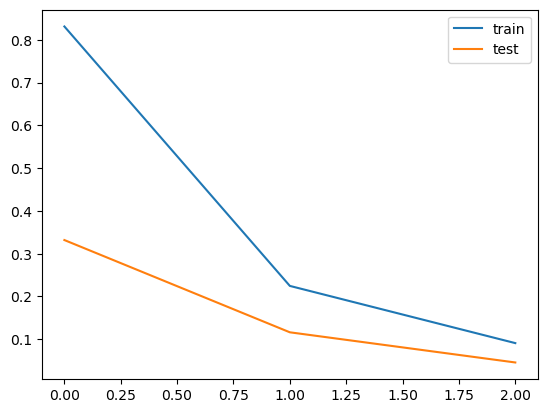

In [34]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [159]:
model.save('model.h5')